# Machine Learning Workshop - Exploring small molecule data

## Accessing this material

All material used in this workshop can be downloaded at **[https://github.com/carlosmr12/mlwk2023](https://github.com/carlosmr12/mlwk2023)**.

Instructions for installation are detailed in the *README.md* file.


## Outline
- Task Overview
- Data Exploring
- Supervised Learning
    - Classification (Less-potent vs Potent PPI inhibitors)


The problem we will solve is **predicting inhibitory activity of small molecules against certain protein-protein interactions (PPIs)**.

Proteins rarely act alone as their functions tend to be regulated. Many molecular processes within a cell are dependents of PPIs. Some PPIs are involved in multiple aggregation-related diseases, such as Creutzfeldt–Jakob and Alzheimer's diseases. The discovery of novel molecules capable of inhibiting these processes can be of great importance for medicine.

Small molecules are low molecular weight molecules that include lipids, monosaccharides, second messengers, other natural products and metabolites, as well as drugs and other xenobiotics. They can interact with receptors and regulate biological processes.

The first thing we need is a data set with inhibitory activity values for real molecules. For this workshop, we will use datasets from [TIMBAL](https://pubmed.ncbi.nlm.nih.gov/23766369/) and [iPPIDB](https://pubmed.ncbi.nlm.nih.gov/33416858/).

The inhibitory activity values are reported in **-log(IC50)**. IC50 means how much of a particular inhibitory drug is needed to inhibit a given biological process or biological component by 50\%. It is measured in uM (micromolar).


## Downloading data and requirements files

In [ ]:
!wget https://raw.githubusercontent.com/carlosmr12/mlwk2023/master/data/ppi_inhibitors.minified.csv
!wget https://raw.githubusercontent.com/carlosmr12/mlwk2023/master/requirements.txt
!wget https://raw.githubusercontent.com/carlosmr12/mlwk2023/master/utils.py

## Installing dependencies

In [ ]:
!pip install -r requirements.txt

## Loading libraries

In [ ]:
%load_ext autoreload
%autoreload 2

from plotly.offline import iplot, init_notebook_mode
from plotly.subplots import make_subplots
from rdkit.Chem.Draw import IPythonConsole #RDKit drawing
# A few settings to improve the quality of structures
from rdkit.Chem import rdDepictor
IPythonConsole.ipython_useSVG = True
rdDepictor.SetPreferCoordGen(True)
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit import Chem

from sklearn import tree
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import cross_val_predict, train_test_split


import numpy as np
import pandas as pd
import time

import utils

import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

## Exploring the data

In [ ]:
df_data = pd.read_csv("ppi_inhibitors.minified.csv") # Load data from file to a DataFrame structure
print(df_data.shape) # .shape displays how the dataframe (matrix) looks like
df_data.head() # .head() displays the first few items in the dataframe

In [ ]:
print(df_data['database'].value_counts())

fig = px.pie(df_data, values=df_data['database'].value_counts().values, \
             names=df_data['database'].value_counts().index, \
             title='Data sources')

fig.show(renderer="colab")

In [ ]:
target = "Experimental IC50 (log10)"
fig = px.histogram(df_data, x=target)
fig.show(renderer="colab")

As seen above the experimental values (IC50) were logarithmized. This conversion is necessary for normalising the targets for the machine learning models, so they can learn better the patterns between input molecules and targets, aiming to provide a better generalisation performance. It is also important to note that ours datasets covers a long range of concentrations.

In [ ]:
columns = ["MolLogP", "Acceptor_Count", "Donor_Count", "NumRotatableBonds", \
           "RingCount", "MolWt"]

fig = make_subplots(rows=3, cols=2, start_cell="bottom-left")

nlines = 3
ncolumns = 2

for i in range(nlines):
    for j in range(ncolumns):
        fig.add_trace(go.Histogram(x=df_data[columns[i+j]], name=columns[i+j]), row=i+1, col=j+1)

fig.show(renderer="colab")

It is also important to note that ours datasets covers, besides a long range of concentrations, also a range of values for diferent properties. This is also important to generate more generalized  models.

An important concept here is **feature**. A feature is a property of the object you’re trying to predict. It can also be referred to as indepent variable, since it is a fixed property of the data point and it does not depend of others variables. These independent variables are essential, because the algorithms need characteristics of the data points as support for the learning process and predicting the labels (in our case inhibitory activity).

The molecules of the dataset are represented through **SMILES**. SMILES is a chemical notation that allows representation of a chemical structure.  They can be represented using simple vocabulary (atom and bond symbols), and few grammar rules:

- ***2-Propanol would be “CC(O)C”***

- ***2-Methylbutanal would be “CC(C)CC(=O)”.***

Using a type of SMILES called ISOMERIC SMILES it is even possible to represent specific isotopism, configuration about double bonds, and chirality.

Below you can see some examples of SMILES in our data:


In [ ]:
print(df_data.iloc[0]['SMILES'])
m = Chem.MolFromSmiles(df_data.iloc[0]['SMILES'])
m

In [ ]:
print(df_data.iloc[1]['SMILES'])
m = Chem.MolFromSmiles(df_data.iloc[1]['SMILES'])
m

In [ ]:
print(df_data.iloc[2]['SMILES'])
m = Chem.MolFromSmiles(df_data.iloc[2]['SMILES'])
m

Browse the [PubChem](https://pubchem.ncbi.nlm.nih.gov/) database for examples of small molecules and input them below to draw their 2D depiction:

In [ ]:
my_smiles = "<PUT YOUR SMILES STRING HERE>"
m = Chem.MolFromSmiles(my_smiles)
m

In order to characterize the molecules of the dataset as **potent** or **less potent** we need to set a threshold value.

Finding this value is not a simple task, it depends of the biological question. According to *Arkin et al, 2014* values **> 5** are considered favorable for in vivo activity.

But you could select a threshold higher or lower in order to predict as positive only very potent small molecules or, vice-verse, respectively.  

- *Arkin MR, Tang Y, Wells JA. Small-molecule inhibitors of protein-protein interactions: progressing toward the reality. Chem Biol. 2014 Sep 18;21(9):1102-14. DOI: 10.1016/j.chembiol.2014.09.001. PMID: 25237857*

Use the variable below to split the dataset into potent and less potent inhibitors

In [ ]:
THRESHOLD_POTENCY = 5

In [ ]:
df_data['potency_class'] = 'less_potent'
df_data.loc[df_data[target] > THRESHOLD_POTENCY, 'potency_class'] = 'potent'

fig = px.pie(df_data, values=df_data['potency_class'].value_counts().values, \
             names=df_data['potency_class'].value_counts().index, \
             color=df_data['potency_class'].value_counts().index, \
             title='PPI inhibitors potency', \
             color_discrete_map={'less_potent':'blue', 'potent':'red'})
fig.show(renderer="colab")

### Additional properties

#### Fingerprints

A **fingerprint** is a fixed length array, where different elements indicate the presence of different features in the molecule. If two molecules have similar fingerprints, that indicates they contain many of the same features, and therefore will likely have similar chemistry.

The small molecules fingerprints can be derived from the SMILES.
  
#### Morgan Fingerprints (Circular Fingerprints)

This family of fingerprints, better known as *circular fingerprints*, is built by applying the Morgan algorithm to a set of user-supplied atom invariants. When generating Morgan fingerprints, the radius of the fingerprint must also be provided.

- *Rogers, D.; Hahn, M. “Extended-Connectivity Fingerprints.” J. Chem. Inf. and Model. 50:742-54 (2010). DOI: 10.1021/ci100050t. PMID: 20426451*

In [ ]:
m = Chem.MolFromSmiles(df_data.iloc[-1]['SMILES'])

N_BITS = 128
info = {}
fpr = AllChem.GetMorganFingerprintAsBitVect(m, useChirality=True, radius=2, nBits=N_BITS, bitInfo=info)

bits_fpr = list(info.keys())

In [ ]:
print(info[bits_fpr[0]])
svg_img = Draw.DrawMorganBit(m, bits_fpr[0], info, useSVG=True)
svg_img

In [ ]:
print(info[bits_fpr[5]])
svg_img1 = Draw.DrawMorganBit(m, bits_fpr[5], info, useSVG=True)
svg_img1

In [ ]:
print(info[bits_fpr[7]])
svg_img1 = Draw.DrawMorganBit(m, bits_fpr[7], info, useSVG=True)
svg_img1

### Generating Fingerprints for all molecules in the dataset

In [ ]:
N_BITS = 64
fprs_data = []

for s in df_data['SMILES']:
    m = Chem.MolFromSmiles(s)
    fpr = AllChem.GetMorganFingerprintAsBitVect(m, useChirality=True, radius=2, nBits=N_BITS)
    fprs_data.append(np.array(fpr))

In [ ]:
df_fprs = pd.DataFrame(np.array(fprs_data))

df_fprs['Experimental IC50 (log10)'] = df_data['Experimental IC50 (log10)']
df_fprs['potency_class'] = df_data['potency_class']

df_fprs.shape
df_fprs.head()

What possible issues could a "binary matrix" have in this case?

- All zeros and all 1s columns

In [ ]:
print("Before:\t{}".format(df_fprs.shape))
X = df_fprs.drop(['Experimental IC50 (log10)', 'potency_class'], axis=1)
# selector = VarianceThreshold(threshold=0) # remove the features that have the same value in all samples
selector = VarianceThreshold(threshold=0.15)
selector.fit(X)
mask = selector.get_support()

df_fprs = X.loc[:, mask].copy()
df_fprs.loc[:, 'Experimental IC50 (log10)'] = df_data['Experimental IC50 (log10)']
df_fprs.loc[:, 'potency_class'] = df_data['potency_class']
print("After:\t{}".format(df_fprs.shape))

### Supervised Learning (Classification)

Your task here is to build a classifier to differentiate potent compounds from less potent ones.

Use the code below to select the select specific columns for the basic features (**df_data**) and fingerprints (**df_fprs**)) datasets.

In [ ]:
target = 'potency_class'

# Basic features dataset
features = ["MolLogP", "Acceptor_Count", "Donor_Count", "NumRotatableBonds", \
           "RingCount", "MolWt"]

X = df_data[features]
y = df_data[target]

# What is the best TEST_SIZE?
TEST_SIZE = 0.26

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, \
                                                    random_state=42)

# Selecting same train and test entries in the Fingerprints dataset
X_train_fpr = df_fprs.iloc[X_train.index]
X_train_fpr = X_train_fpr.loc[:,38:63] # Selecting only a specific set of features/columns using indexes
X_test_fpr = df_fprs.iloc[X_test.index]
X_test_fpr = X_test_fpr.loc[:,38:63] # It needs to be the equal to the X_train_fpr

y_train_fpr = df_fprs.iloc[X_train.index][target]
y_test_fpr = df_fprs.iloc[X_test.index][target]

# print(y_train.value_counts())
utils.plot_train_test_class(y_train, y_test)

#### Why is data splitting necessary?

If you check in the code lines above you used a function "train_test_split". This function divided our data into two subsets. One part is used to evaluate or test the data and the other to train the model.

This is step is very important because it helps ensure the creation of data models and processes that use data models are accurate. Using the the test set (a subset completely unseen during trainning) you can estimate the performance of the model when it is applied to new data points.  

#### Decision Tree

Decision trees are composed of if/else questions disposed in a hierarchical manner, following these questions the model is capable of reaching a decision. In the case of our question, the actual output are 'less_potent' or 'potent' labels. The decision to reach prediction is based on the features (graph based signatures and auxiliary features) we used as input for the ML algorithm.

##### Training on the basic set of features

In [ ]:
clf = tree.DecisionTreeClassifier(max_depth=3)
y_pred_train = cross_val_predict(clf, X_train, y_train, cv=5)

clf.fit(X_train, y_train)
y_pred_test = clf.predict(X_test)

utils.gen_train_test_cm(y_train, y_pred_train, y_test, y_pred_test, ['less_potent', 'potent'])

In [ ]:
utils.gen_train_test_roc(y_train, y_pred_train, y_test, y_pred_test, ['less_potent', 'potent'])

What does the decision tree looks like?

In [ ]:
fig, axes = plt.subplots(nrows=1 ,ncols=1, figsize=(9,6), dpi=300)
tree.plot_tree(clf, feature_names=X_train.columns, class_names=['less_potent', 'potent'], filled=True)
plt.show()

Which features are more important for the model?

In [ ]:
utils.feat_importance(clf)

##### Training on the Fingerprint-based set of features

Performance on Training (k-fold cross validation)
              precision    recall  f1-score   support

 less_potent       0.57      0.43      0.49       357
      potent       0.69      0.80      0.74       562

    accuracy                           0.65       919
   macro avg       0.63      0.61      0.61       919
weighted avg       0.64      0.65      0.64       919

Performance on Test set
              precision    recall  f1-score   support

 less_potent       0.62      0.46      0.53       137
      potent       0.67      0.80      0.73       186

    accuracy                           0.65       323
   macro avg       0.65      0.63      0.63       323
weighted avg       0.65      0.65      0.64       323



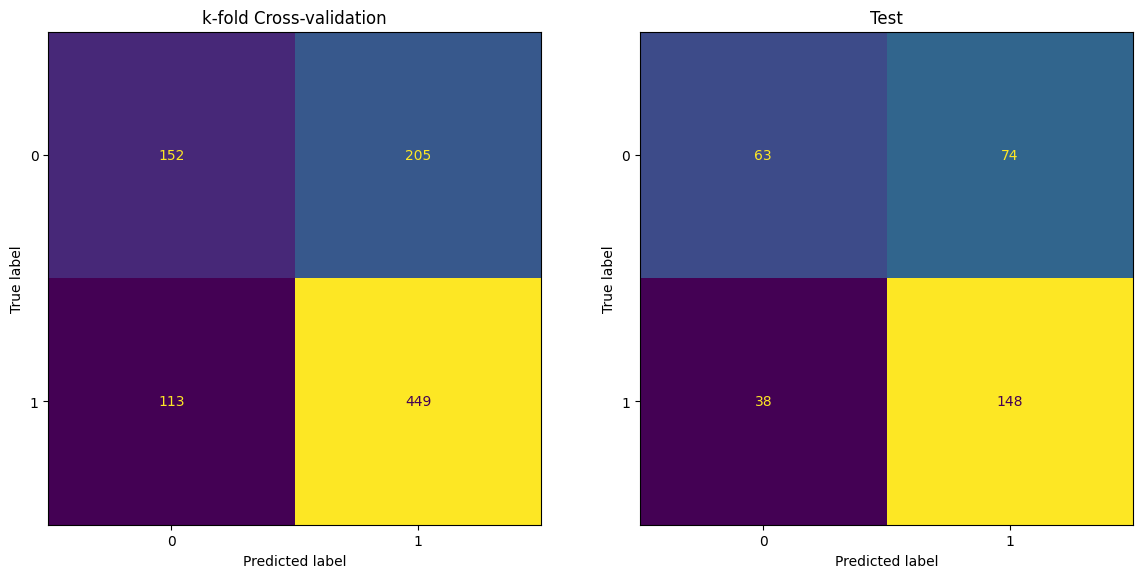

In [ ]:
clf = tree.DecisionTreeClassifier(max_depth=3)
y_pred_train_fpr = cross_val_predict(clf, X_train_fpr, y_train_fpr, cv=5)

clf.fit(X_train_fpr, y_train_fpr)
y_pred_test_fpr = clf.predict(X_test_fpr)

utils.gen_train_test_cm(y_train_fpr, y_pred_train_fpr, y_test_fpr, y_pred_test_fpr, ['less_potent', 'potent'])

In [ ]:
utils.gen_train_test_roc(y_train_fpr, y_pred_train_fpr, y_test_fpr, y_pred_test_fpr, ['less_potent', 'potent'])

What does the decision tree looks like?

In [ ]:
fig, axes = plt.subplots(nrows=1 ,ncols=1, figsize=(9,6), dpi=300)
tree.plot_tree(clf, feature_names=X_train_fpr.columns, class_names=['less_potent', 'potent'], filled=True)
plt.show()

Which features are more important for the model?

In [ ]:
utils.feat_importance(clf)